In [1]:
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 24,
    })

In [14]:
# To plot arrows
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)
        
def plot_iteration(x, d=None):
    ax = plt.figure(figsize=(12, 9)).add_subplot(projection='3d')
    ax.set_xlim([0,15])
    ax.set_xlabel(r"$x_1$")
    ax.set_xticks([])
    ax.set_ylim([0,15])
    ax.set_ylabel(r"$x_2$")
    ax.set_yticks([])
    ax.set_zlim([0,15])
    ax.set_zlabel(r"$x_3$")
    ax.set_zticks([])    
    ax.view_init(20, 15)
    # ax.dist = 10 

    # Plot feasible region
    xv = [0, 10, 0, 0, 4]
    yv = [0, 0, 10, 0, 4]
    zv = [0, 0, 0, 10, 4]
    vertices = [[1, 3, 4], [1, 2, 4], [2, 3, 4]]
    tupleList = list(zip(xv, yv, zv))
    poly3d = [[tupleList[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]
    ax.add_collection3d(Poly3DCollection(poly3d, linewidths=1, alpha=0.2))
    ax.add_collection3d(Line3DCollection(poly3d, colors='k', linewidths=0.5, linestyles=':'))
    # This line not plotted by default
    ax.plot([10, 4], [0, 4], [0, 4], color="k", linewidth=0.5, linestyle=":")  
    
    # plot arrow
    if d is not None:
        ax.text(4, 3, -6, r"$d = ({0:.2}, {1:.2}, {2:.2})$".format(d[0], d[1], d[2]), color='k')
        d = 3 * d/np.linalg.norm(d[:2])  # Normalize d to plot
        arw = Arrow3D([x[0],x[0] + d[0]],[x[1],x[1] + d[1]],[x[2], x[2] + d[2]], 
                       arrowstyle="-|>", color="k", lw = 3, mutation_scale=25)
        ax.add_artist(arw)

    # Plot x and x_next
    ax.scatter(x[0], x[1], x[2], marker='o', s=70, color='k', facecolors='k')
    ax.text(4, 3, -4, r"$x = ({0}, {1}, {2})$".format(x[0], x[1], x[2]), color='k')

    plt.show()

In [15]:
def simplex_iteration(x, B, problem, verbose=False):
    """Perform one simplex iteration given 
    - basic feasible solution x
    - basis B
    
    It returns new x, new basis and termination flag (true/false)
    """
    A, b, c = problem['A'], problem['b'], problem['c']
    m, n = A.shape
    A_B = A[:, B]
    if verbose:
        print("x =", x)
        print("B =", B)
        print("c' * x =", c @ x)
        print("A_B =\n", A_B)
    
    # Compute reduced cost vector
    p = la.solve(A_B.T, c[B])
    c_bar = c - A.T @ p
    if verbose:
        print("c_bar", c_bar)
    
    # Check optimality
    if np.all(c_bar >= 0):
        if verbose:
            print("Optimal solution found!")
        return x, B, True

    # Choose j such that c_bar < 0 (first one)
    j = np.where(c_bar < 0)[0][0]
    if verbose:
        print("j =", j)
    
    # Compute search direction d
    d = np.zeros(n)
    d[j] = 1
    d[B] = la.solve(A_B, -A[:, j])
    if verbose:
        print("d =", d, "\t( d_B =", d[B], ")")
    
    # Check for unboundedness
    if np.all(d >= 0):
        if verbose:
            print("Unbounded problem!")
        return None, None, True
    
    # Compute step length theta
    d_i = np.where(d[B] < 0)[0]
    theta = np.min(- x[B[d_i]] / d[B[d_i]])
    i = B[d_i[np.argmin(- x[B[d_i]] / d[B[d_i]])]]
    if verbose:
        print("i = ", i)
        print("theta = min_{i | d_i < 0} (-x_i/d_i) = min(", - x[B[d_i]] / d[B[d_i]], ") =", theta)
    
    # Compute next point
    x_next = x + theta * d
    
    if verbose:
        print("x_next = x + theta * d =", x_next)
    
    # Compute next basis
    B_next = B
    B_next[np.where(B == i)[0]] = j
    
    if verbose:
            plot_iteration(x, d)
  
    return x_next, B_next, False

def simplex_algorithm(x, B, problem, max_iter=1000, verbose=False):

    for k in range(max_iter):
        
        if verbose:
            print("\nIteration", k)
            
        x, B, end = simplex_iteration(x, B, problem, verbose=verbose)
        
        if end:
            plot_iteration(x)
            break
            
        input("Press Enter to continue...")
    return x, B

In [16]:
# Another example
c = np.array([-10, -12, -12, 0, 0, 0])
A = np.array([[1, 2, 2, 1, 0, 0],
              [2, 1, 2, 0, 1, 0],
              [2, 2, 1, 0, 0, 1]])
b = np.array([20, 20, 20])

In [17]:
# initial basic feasible solution and basic basis
x0 = np.array([0, 0, 0, 20, 20, 20])
B0 = np.array([3, 4, 5])


Iteration 0
x = [ 0  0  0 20 20 20]
B = [3 4 5]
c' * x = 0
A_B =
 [[1 0 0]
 [0 1 0]
 [0 0 1]]
c_bar [-10. -12. -12.   0.   0.   0.]
j = 0
d = [ 1.  0.  0. -1. -2. -2.] 	( d_B = [-1. -2. -2.] )
i =  4
theta = min_{i | d_i < 0} (-x_i/d_i) = min( [20. 10. 10.] ) = 10.0
x_next = x + theta * d = [10.  0.  0. 10.  0.  0.]


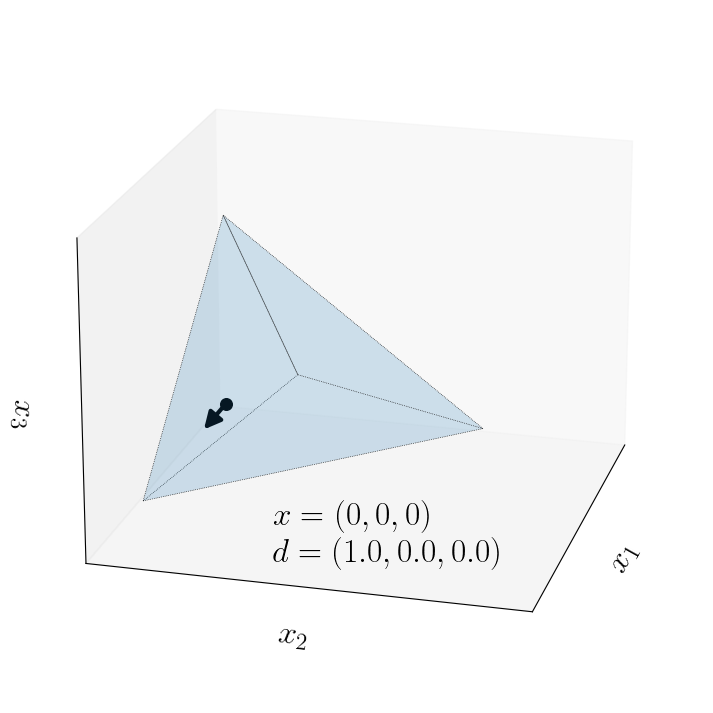

Press Enter to continue... 



Iteration 1
x = [10.  0.  0. 10.  0.  0.]
B = [3 0 5]
c' * x = -100.0
A_B =
 [[1 1 0]
 [0 2 0]
 [0 2 1]]
c_bar [ 0. -7. -2.  0.  5.  0.]
j = 1
d = [-0.5  1.   0.  -1.5  0.  -1. ] 	( d_B = [-1.5 -0.5 -1. ] )
i =  5
theta = min_{i | d_i < 0} (-x_i/d_i) = min( [ 6.66666667 20.          0.        ] ) = 0.0
x_next = x + theta * d = [10.  0.  0. 10.  0.  0.]


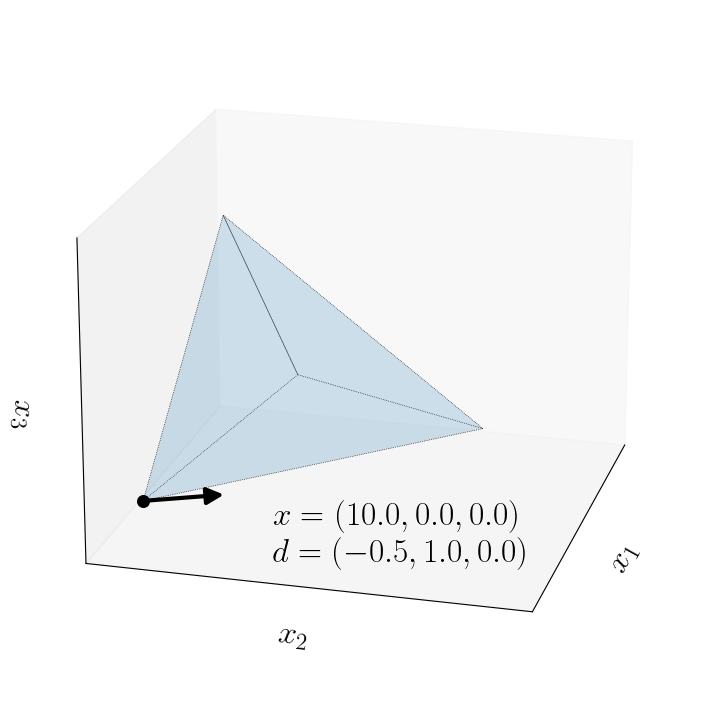

Press Enter to continue... 



Iteration 2
x = [10.  0.  0. 10.  0.  0.]
B = [3 0 1]
c' * x = -100.0
A_B =
 [[1 1 2]
 [0 2 1]
 [0 2 2]]
c_bar [ 0.  0. -9.  0. -2.  7.]
j = 2
d = [-1.5  1.   1.  -2.5  0.   0. ] 	( d_B = [-2.5 -1.5  1. ] )
i =  3
theta = min_{i | d_i < 0} (-x_i/d_i) = min( [4.         6.66666667] ) = 4.0
x_next = x + theta * d = [4. 4. 4. 0. 0. 0.]


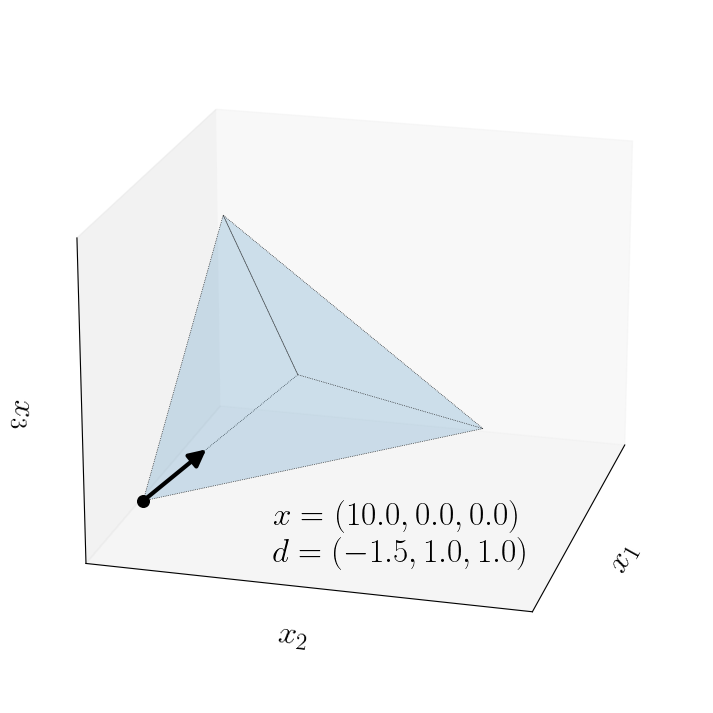

Press Enter to continue... 



Iteration 3
x = [4. 4. 4. 0. 0. 0.]
B = [2 0 1]
c' * x = -136.0
A_B =
 [[2 1 2]
 [2 2 1]
 [1 2 2]]
c_bar [0.  0.  0.  3.6 1.6 1.6]
Optimal solution found!


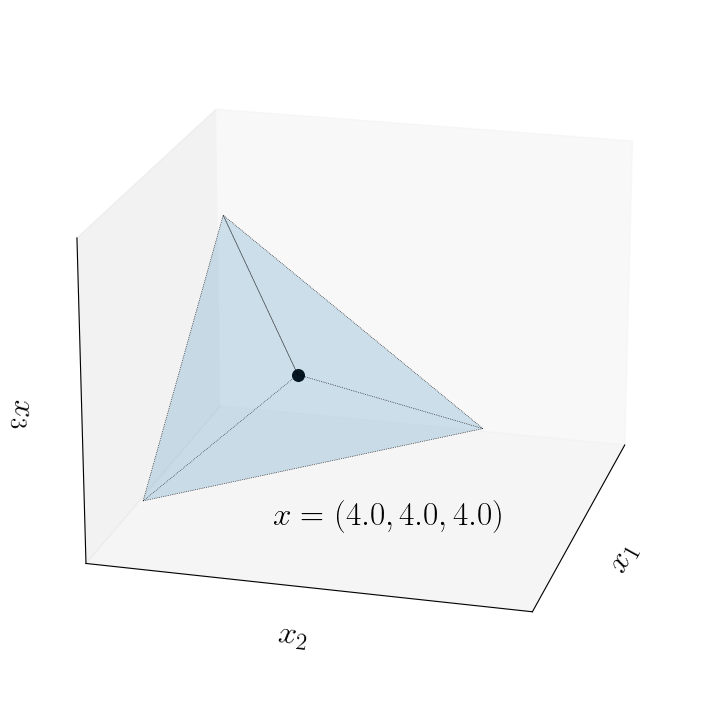

In [18]:
x_simplex, B_simplex = simplex_algorithm(x0, B0, {'c': c, 'A': A, 'b': b}, verbose=True)

In [12]:
x_simplex

array([4., 4., 4., 0., 0., 0.])

In [13]:
c @ x_simplex

-136.0